In [39]:
# SETUP 

import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import gym
import pylab
import numpy as np
import cv2
import matplotlib.pyplot as plt
env_name = 'CartPole-v0'


In [38]:

def ActorCritic(input_shape, action_space, lr):
    X_input = Input(input_shape)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(200, activation="relu")(X)
    X = Dense(20, activation="relu")(X)
    action = Dense(action_space, activation="softmax")(X)
    value = Dense(1)(X)

    Actor = Model(inputs = X_input, outputs = action)
    Critic = Model(inputs = X_input, outputs = value)
    Actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr))

  
    Critic.compile(loss='mse', optimizer=RMSprop(lr=lr))

    return Actor, Critic

In [50]:


class CartPoleActorCritic:
    def __init__(self, env_name):
        #Set params
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = 2
        self.EPISODES = 1000
        self.lr = 0.0001
        self.REM_STEP = 4
        self.gamma = 0.95 
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average  = [], [], []
        self.state_size = (4,4)
        self.image_memory = np.zeros(self.state_size)
        self.rewardsforplot = []
        self.avgrewards = []

        # Initiate models
        self.Actor, self.Critic = ActorCritic(input_shape=self.state_size, 
                                              action_space = self.action_size, 
                                              lr=self.lr)
    def store(self, state, action, reward):
        '''Make a record of states, actions and rewards'''

        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)


    def act(self, state):
      ''' Make a decision based on the actor model'''
      prediction = self.Actor.predict(state)[0]
      action = np.random.choice(self.action_size, p=prediction)
      return action

    def discount_rewards(self, reward):
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: 
                running_add = 0
            running_add = running_add * self.gamma + reward[i]
            discounted_r[i] = running_add

            #Normalize the result
            discounted_r -= np.mean(discounted_r)
            discounted_r /= np.std(discounted_r + 1e-9) # divide by standard deviation with a small value to avoid /0

        return discounted_r
    def getavg(self, score, episode):
      self.scores.append(score)
      self.episodes.append(episode)
      self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
      return self.average[-1]

                
    def replay(self):
      ''' Fit model and reset memory'''
        # reshape for training
      states = np.vstack(self.states)
      actions = np.vstack(self.actions)

        # Compute discounted rewards
      discounted_r = self.discount_rewards(self.rewards)

        # Get Critic network predictions
      values = self.Critic.predict(states)[:, 0]

        # Subtract baseline from rewards
      advantages = discounted_r - values
        # training nets
      self.Actor.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
      self.Critic.fit(states, discounted_r, epochs=1, verbose=0)
        # reset for next ep
      self.states, self.actions, self.rewards = [], [], []

    def Preprocess(self, frame):
      self.image_memory = np.roll(self.image_memory, 1, axis = 0)
      self.image_memory[0,:] = frame
      return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
      "get next state for new ep"
      frame = self.env.reset()
      state = self.Preprocess(frame)
      return state

    def step(self, action):
      "get next state with an episode and record details"
      next_state, reward, done, info = self.env.step(action)
      next_state = self.Preprocess(next_state)
      return next_state, reward, done, info
    
    def run(self):
      "Run model"
      for e in range(self.EPISODES):
          state = self.reset()
          done, score= False, 0
          while not done:
                #next action
              action = self.act(state)
              next_state, reward, done, _ = self.step(action) # Go to next state
              # Memorize (state, action, reward) for training
              self.store(state, action, reward)
              # Update current state
              state = next_state
              score += reward
              if done:
                  average = self.getavg(score, e)
                  self.avgrewards.append(average)
                  self.rewardsforplot.append(score)
                  self.replay()
      self.env.close()

env_name = 'CartPole-v0'
go = CartPoleActorCritic(env_name)
  

In [51]:
# RUN MODEL
go = CartPoleActorCritic(env_name)
go.run()

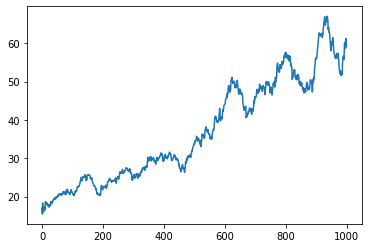

In [52]:

plt.plot(go.avgrewards)